# Static Analysis of a Joined-Wing

In this example we consider the joined-wing model proposed by Blair in "An Equivalent
Beam Formulation for Joined-Wings in a Post-Buckled State" and optimized by Green
et al. in "Structural Optimization of Joined-Wing Beam Model with Bend-Twist
Coupling using Equivalent Static Loads".

![](../assets/static-joined-wing-drawing.png)

In [1]:
using GXBeam, LinearAlgebra

# Set endpoints of each beam
p1 = [-7.1726, -12, -3.21539]
p2 = [-5.37945, -9, -2.41154]
p3 = [-3.5863, -6, -1.6077]
p4 = [-1.79315, -3, -0.803848]
p5 = [0, 0, 0]
p6 = [7.1726, -12, 3.21539]

# get transformation matrix for left beams

# transformation from intermediate frame to global frame
tmp1 = sqrt(p1[1]^2 + p1[2]^2)
c1, s1 = -p1[1]/tmp1, -p1[2]/tmp1
rot1 = [c1 -s1 0; s1 c1 0; 0 0 1]

# transformation from local beam frame to intermediate frame
tmp2 = sqrt(p1[1]^2 + p1[2]^2 + p1[3]^2)
c2, s2 = tmp1/tmp2, -p1[3]/tmp2
rot2 = [c2 0 -s2; 0 1 0; s2 0 c2]

Cab_1 = rot1*rot2

# get transformation matrix for right beam

# transformation from intermediate frame to global frame
tmp1 = sqrt(p6[1]^2 + p6[2]^2)
c1, s1 = p6[1]/tmp1, p6[2]/tmp1
rot1 = [c1 -s1 0; s1 c1 0; 0 0 1]

# transformation from local beam frame to intermediate frame
tmp2 = sqrt(p6[1]^2 + p6[2]^2 + p6[3]^2)
c2, s2 = tmp1/tmp2, p6[3]/tmp2
rot2 = [c2 0 -s2; 0 1 0; s2 0 c2]

Cab_2 = rot1*rot2

# beam 1
L_b1 = norm(p2-p1)
r_b1 = p1
nelem_b1 = 5
lengths_b1, xp_b1, xm_b1, Cab_b1 = discretize_beam(L_b1, r_b1, nelem_b1;
    frame = Cab_1)
compliance_b1 = fill(Diagonal([1.05204e-9, 3.19659e-9, 2.13106e-8, 1.15475e-7,
    1.52885e-7, 7.1672e-9]), nelem_b1)

# beam 2
L_b2 = norm(p3-p2)
r_b2 = p2
nelem_b2 = 5
lengths_b2, xp_b2, xm_b2, Cab_b2 = discretize_beam(L_b2, r_b2, nelem_b2;
    frame = Cab_1)
compliance_b2 = fill(Diagonal([1.24467e-9, 3.77682e-9, 2.51788e-8, 1.90461e-7,
    2.55034e-7, 1.18646e-8]), nelem_b2)

# beam 3
L_b3 = norm(p4-p3)
r_b3 = p3
nelem_b3 = 5
lengths_b3, xp_b3, xm_b3, Cab_b3 = discretize_beam(L_b3, r_b3, nelem_b3;
    frame = Cab_1)
compliance_b3 = fill(Diagonal([1.60806e-9, 4.86724e-9, 3.24482e-8, 4.07637e-7,
    5.57611e-7, 2.55684e-8]), nelem_b3)

# beam 4
L_b4 = norm(p5-p4)
r_b4 = p4
nelem_b4 = 5
lengths_b4, xp_b4, xm_b4, Cab_b4 = discretize_beam(L_b4, r_b4, nelem_b4;
    frame = Cab_1)
compliance_b4 = fill(Diagonal([2.56482e-9, 7.60456e-9, 5.67609e-8, 1.92171e-6,
    2.8757e-6, 1.02718e-7]), nelem_b4)

# beam 5
L_b5 = norm(p6-p5)
r_b5 = p5
nelem_b5 = 20
lengths_b5, xp_b5, xm_b5, Cab_b5 = discretize_beam(L_b5, r_b5, nelem_b5;
    frame = Cab_2)
compliance_b5 = fill(Diagonal([2.77393e-9, 7.60456e-9, 1.52091e-7, 1.27757e-5,
    2.7835e-5, 1.26026e-7]), nelem_b5)

# combine elements and points into one array
nelem = nelem_b1 + nelem_b2 + nelem_b3 + nelem_b4 + nelem_b5
points = vcat(xp_b1, xp_b2[2:end], xp_b3[2:end], xp_b4[2:end], xp_b5[2:end])
start = 1:nelem
stop = 2:nelem + 1
lengths = vcat(lengths_b1, lengths_b2, lengths_b3, lengths_b4, lengths_b5)
midpoints = vcat(xm_b1, xm_b2, xm_b3, xm_b4, xm_b5)
Cab = vcat(Cab_b1, Cab_b2, Cab_b3, Cab_b4, Cab_b5)
compliance = vcat(compliance_b1, compliance_b2, compliance_b3, compliance_b4,
    compliance_b5)

# create assembly
assembly = Assembly(points, start, stop;
    compliance = compliance,
    frames = Cab,
    lengths = lengths,
    midpoints = midpoints)

Fz = range(0, 70e3, length=141)

# pre-allocate memory to reduce run-time
ijoint = nelem_b1 + nelem_b2 + nelem_b3 + nelem_b4 + 1
prescribed_points = [1, ijoint, nelem+1]
static = true
system = System(assembly, static; prescribed_points)

linear_states = Vector{AssemblyState{Float64}}(undef, length(Fz))
for i = 1:length(Fz)

    # create dictionary of prescribed conditions
    prescribed_conditions = Dict(
        # fixed endpoint on beam 1
        1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0,
            theta_z=0),

        # force applied on point 4
        nelem_b1 + nelem_b2 + nelem_b3 + nelem_b4 + 1 => PrescribedConditions(
            Fz = Fz[i]),

        # fixed endpoint on last beam
        nelem+1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0,
            theta_z=0),
    )

    static_analysis!(system, assembly;
        prescribed_conditions = prescribed_conditions,
        linear = true)

    linear_states[i] = AssemblyState(system, assembly;
        prescribed_conditions = prescribed_conditions)

end

reset_state!(system)
nonlinear_states = Vector{AssemblyState{Float64}}(undef, length(Fz))
for i = 1:length(Fz)

    # create dictionary of prescribed conditions
    prescribed_conditions = Dict(
        # fixed endpoint on beam 1
        1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0,
            theta_z=0),

        # force applied on point 4
        nelem_b1 + nelem_b2 + nelem_b3 + nelem_b4 + 1 => PrescribedConditions(
            Fz = Fz[i]),

        # fixed endpoint on last beam
        nelem+1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0,
            theta_z=0),
    )

    static_analysis!(system, assembly;
        prescribed_conditions=prescribed_conditions, reset_state=false)

    nonlinear_states[i] = AssemblyState(system, assembly;
        prescribed_conditions = prescribed_conditions)

end

reset_state!(system)
nonlinear_follower_states = Vector{AssemblyState{Float64}}(undef, length(Fz))
for i = 1:length(Fz)
    # create dictionary of prescribed conditions
    prescribed_conditions = Dict(
        # fixed endpoint on beam 1
        1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0,
            theta_z=0),

        # force applied on point 4
        nelem_b1 + nelem_b2 + nelem_b3 + nelem_b4 + 1 => PrescribedConditions(
            Fz_follower = Fz[i]),

        # fixed endpoint on last beam
        nelem+1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0,
            theta_z=0),
    )

    static_analysis!(system, assembly;
        prescribed_conditions=prescribed_conditions, reset_state=false)

    nonlinear_follower_states[i] = AssemblyState(system, assembly;
        prescribed_conditions = prescribed_conditions)

end

nothing #hide

Note that we incrementally increased the load from 0 to 70 kN in order to ensure that we
obtained converged solutions.

To visualize the differences between the different types of analyses we can plot the
load deflection curve.

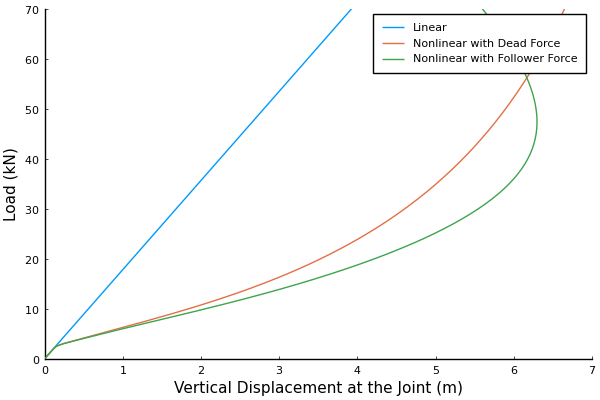

In [2]:
using Plots
pyplot()

plot(
    xlim = (0, 7),
    xticks = 0:1:7,
    xlabel = "Vertical Displacement at the Joint (m)",
    yticks = 0:10:70,
    ylim = (0, 70),
    ylabel = "Load (kN)",
    grid = false,
    overwrite_figure=false
    )
uz_l = [linear_states[i].points[ijoint].u[3] for i = 1:length(Fz)]
uz_nl = [nonlinear_states[i].points[ijoint].u[3] for i = 1:length(Fz)]
uz_fnl = [nonlinear_follower_states[i].points[ijoint].u[3] for i = 1:length(Fz)]

plot!(uz_l, Fz./1e3, label="Linear")
plot!(uz_nl, Fz./1e3, label="Nonlinear with Dead Force")
plot!(uz_fnl, Fz./1e3, label="Nonlinear with Follower Force")

This plot matches the plot provided by Wenbin Yu in "GEBT: A general-purpose nonlinear
analysis tool for composite beams".

We can also visualize the deformed geometry and inspect the associated point and element
data for any of these operating conditions conditions using ParaView.  To demonstrate
we will visualize the 70kN follower force condition and set the color gradient to
match the magnitude of the deflections.

In [3]:
airfoil  = [ #FX 60-100 airfoil
    0.0000000 0.0000000;
    0.0010700 0.0057400;
    0.0042800 0.0114400;
    0.0096100 0.0177500;
    0.0170400 0.0236800;
    0.0265300 0.0294800;
    0.0380600 0.0352300;
    0.0515600 0.0405600;
    0.0669900 0.0460900;
    0.0842700 0.0508600;
    0.1033200 0.0556900;
    0.1240800 0.0598900;
    0.1464500 0.0640400;
    0.1703300 0.0675400;
    0.1956200 0.0708100;
    0.2222100 0.0733900;
    0.2500000 0.0756500;
    0.2788600 0.0772000;
    0.3086600 0.0783800;
    0.3392800 0.0788800;
    0.3705900 0.0789800;
    0.4024500 0.0784500;
    0.4347400 0.0775000;
    0.4673000 0.0759600;
    0.5000000 0.0740900;
    0.5327000 0.0717400;
    0.5652600 0.0691100;
    0.5975500 0.0660800;
    0.6294100 0.0627500;
    0.6607200 0.0590500;
    0.6913400 0.0551100;
    0.7211400 0.0508900;
    0.7500000 0.0465200;
    0.7777900 0.0420000;
    0.8043801 0.0374700;
    0.8296700 0.0329800;
    0.8535500 0.0286400;
    0.8759201 0.0244700;
    0.8966800 0.0205300;
    0.9157300 0.0168100;
    0.9330100 0.0134200;
    0.9484400 0.0103500;
    0.9619400 0.0076600;
    0.9734700 0.0053400;
    0.9829600 0.0034100;
    0.9903900 0.0019300;
    0.9957200 0.0008600;
    0.9989300 0.0002300;
    1.0000000 0.0000000;
    0.9989300 0.0001500;
    0.9957200 0.0007000;
    0.9903900 0.0015100;
    0.9829600 0.00251;
    0.9734700 0.00377;
    0.9619400 0.00515;
    0.9484400 0.00659;
    0.9330100 0.00802;
    0.9157300 0.00941;
    0.8966800 0.01072;
    0.8759201 0.01186;
    0.8535500 0.0128;
    0.8296700 0.01347;
    0.8043801 0.01381;
    0.7777900 0.01373;
    0.7500000 0.01329;
    0.7211400 0.01241;
    0.6913400 0.01118;
    0.6607200 0.00951;
    0.6294100 0.00748;
    0.5975500 0.00496;
    0.5652600 0.00217;
    0.532700  -0.00092;
    0.500000  -0.00405;
    0.467300  -0.00731;
    0.434740  -0.01045;
    0.402450  -0.01357;
    0.370590  -0.01637;
    0.339280  -0.01895;
    0.308660  -0.021;
    0.278860  -0.02275;
    0.250000  -0.02389;
    0.222210  -0.02475;
    0.195620  -0.025;
    0.170330  -0.02503;
    0.146450  -0.02447;
    0.124080  -0.02377;
    0.103320  -0.02246;
    0.084270  -0.0211;
    0.066990  -0.01913;
    0.051560  -0.0173;
    0.038060  -0.01481;
    0.026530  -0.01247;
    0.017040  -0.0097;
    0.009610  -0.00691;
    0.004280  -0.00436;
    0.001070  -0.002;
    0.0        0.0;
]

section = zeros(3, size(airfoil, 1))
for ic = 1:size(airfoil, 1)
    section[1,ic] = airfoil[ic,1] - 0.5
    section[2,ic] = 0
    section[3,ic] = airfoil[ic,2]
end

write_vtk("static-joined-wing-visualization", assembly, nonlinear_follower_states[end];
    sections = section)

![](../assets/static-joined-wing-visualization.png)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*